# Mattermost Lunch Channel History

- Data Source: [Mattermost API](https://api.mattermost.com/), [CCTB instance](https://cctb-intern.biologie.uni-wuerzburg.de/)
- Tasks:
	- Part I - June 2024: retrieving chat history data through the mattermost API
	- Part II - September 2024: analyzing messages in the lunch channel
- Language: [R](https://www.r-project.org/)

## Potential questions

- At what times is usually posted in the lunch channel
- Extract "the main lunch message" (MLM)
- How many reactions does MLM retrieve
    - Is there a correlation by day of week
    - Is there a trend over time
- Who posts MLM most often?
- Who attends most often without posting MLM?
- For an individal user get the attendance over time
- …

In [3]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()   masks base::%||%()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
theme_set(theme_light())

In [5]:
set.seed(42)
"Jana Sascha Mike Markus" %>%  str_split(" ") %>% unlist %>% sample %>% str_c(collapse=" → ")

[1] "Jana → Markus → Mike → Sascha"

## 1. Data loading

Load files:
- `messages.csv`
- `reactions.csv`
- `files.csv`

In [8]:
messages <- read_csv("messages.csv")
reactions <- read_csv("reactions.csv")
files <- read_csv("files.csv")

Rows: 6934 Columns: 6


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): post_id, message, username
dbl  (2): num_reactions, num_files
dttm (1): create_at



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 3611 Columns: 5


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (4): post_id, emoji_name, username, emoji
dttm (1): create_at



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 217 Columns: 3


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): post_id, file_id, link



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [12]:
reactions %>% head

post_id,create_at,emoji_name,username,emoji
<chr>,<dttm>,<chr>,<chr>,<chr>
ng3m9o5c5igw3gpgg1dqmgs4mw,2017-08-18 11:57:23,+1,lulei,👍
atnyf76f1tb1fmznhrk4s3wohr,2017-08-21 11:50:04,+1,sonja,👍
atnyf76f1tb1fmznhrk4s3wohr,2017-08-21 11:52:22,+1,iimog,👍
eh5ge6nnf7np5q61rqpfwhmqaw,2017-08-23 11:24:45,+1,sonja,👍
eh5ge6nnf7np5q61rqpfwhmqaw,2017-08-23 11:26:44,+1,alexanderkeller,👍
eh5ge6nnf7np5q61rqpfwhmqaw,2017-08-23 11:49:19,+1,t.paul,👍


In [13]:
messages %>% head

post_id,create_at,message,username,num_reactions,num_files
<chr>,<dttm>,<chr>,<chr>,<dbl>,<dbl>
h957oi1t63rf5b6p4pqfhiis5h,2016-05-02 12:02:13,Also ich habe etwas dabei,greatfireball,0,0
rpwuii8hci8ezmn3d41u9d58fc,2016-05-02 12:03:02,ich gehe mir jetzt was holen,nterhoeven,0,0
e8bnwq8c7fdf5k7zpqyeihougr,2016-05-02 12:03:24,Alles klar,greatfireball,0,0
sku34dhpntdfdmc5d9ky9a9yso,2016-05-02 12:20:33,Hallo @joerg,greatfireball,0,0
hi38ssjpb3yqz88dk83tzjq5zr,2016-05-02 12:20:35,Essen?,greatfireball,0,0
dux74xuq738u38z384wg8mri1e,2016-05-02 12:20:36,:smile:,greatfireball,0,0


## Trying to find MLM

In [15]:
messages %>% select(message)

message
<chr>
Also ich habe etwas dabei
ich gehe mir jetzt was holen
Alles klar
Hallo @joerg
Essen?
:smile:
(wave) auch da!
old school
:wave:


Quality control: Each message contains either text or file

In [17]:
messages %>% filter(is.na(message), num_files == 0)

post_id,create_at,message,username,num_reactions,num_files
<chr>,<dttm>,<chr>,<chr>,<dbl>,<dbl>


In [18]:
messages %>% count(message, sort=TRUE)

message,n
<chr>,<int>
11:15?,99
NA,94
:+1:,79
yes,72
ok,51
I have something,40
?,37
:thumbsup:,35
mensa?,35


In [22]:
messages %>% filter(message == "I have something") %>% count(username, sort=TRUE)

username,n
<chr>,<int>
franzi_s,17
iimog,12
nterhoeven,4
sonja,4
greatfireball,3


In [27]:
messages %>% filter(str_detect(message, "\\?")) %>% count(message, sort=TRUE)

message,n
<chr>,<int>
11:15?,99
?,37
mensa?,35
Mensa?,29
@kitchengroup lunch at 12?,23
go?,23
lunch?,23
now?,20
coffee?,17


In [30]:
messages %>% filter(str_detect(message, "\\d\\d:\\d\\d")) %>% count(message, sort = TRUE)

message,n
<chr>,<int>
11:15?,99
11:45?,15
mensa 11:25?,12
mensa 11:45?,11
mensa 11:15?,9
11:40?,8
mensa 11:40?,8
mensa 11:20?,7
mensa at 11:25?,7


In [32]:
messages %>% filter(message == "short (!) Mate break at 14:00")

post_id,create_at,message,username,num_reactions,num_files
<chr>,<dttm>,<chr>,<chr>,<dbl>,<dbl>
rrc6dqeaj78k9xxe4rwnzz7r4y,2022-07-19 13:50:15,short (!) Mate break at 14:00,janablechschmidt,0,0


In [35]:
messages %>% filter(create_at > ymd_hms("2022-07-19 13:50:15")) %>% head(3)

post_id,create_at,message,username,num_reactions,num_files
<chr>,<dttm>,<chr>,<chr>,<dbl>,<dbl>
rrc6dqeaj78k9xxe4rwnzz7r4y,2022-07-19 13:50:15,short (!) Mate break at 14:00,janablechschmidt,0,0
ysj63h435jng5f4ueqm6ksjd4a,2022-07-20 07:09:50,there is ice cream in the fridge to make the heat more bearable :sunny: :icecream:,janablechschmidt,5,0
j5rf7bkxbpn6tnynj55xcdhyta,2022-07-20 12:24:43,lunch at 12:27?,maximilian_p,0,0


### Is the first message of the day the MLM (in most cases)?

In [72]:
MLM <- messages %>%
    mutate(my_day = floor_date(create_at, "day")) %>%
    group_by(my_day) %>% filter(row_number() == 1)

In [73]:
MLM

post_id,create_at,message,username,num_reactions,num_files,my_day
<chr>,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<dttm>
h957oi1t63rf5b6p4pqfhiis5h,2016-05-02 12:02:13,Also ich habe etwas dabei,greatfireball,0,0,2016-05-02
hmdk3e5w1pf5xptgxr9hc6niqy,2016-05-03 11:24:55,What about lunch today?,greatfireball,0,0,2016-05-03
yepxejb3ejnj9nmsb75eod1bga,2016-05-04 11:30:47,essenspläne heute?,nterhoeven,0,0,2016-05-04
6hmbwo4exjroxgbixdpo6f64ar,2016-05-06 11:33:50,What are the plans for today?,iimog,0,0,2016-05-06
pqrbzh9zb7f67qoodx14qyeoiw,2016-05-09 11:28:43,Wie sieht es denn heute mit Essensplänen aus? Ich müsste mir was holen.,franzi_s,0,0,2016-05-09
8yinzh7xhpbxtr71cgwewtoz7e,2016-05-10 10:42:33,Hey... What about lunch today? I have something...,greatfireball,0,0,2016-05-10
x3epctasxt837dnm7f8e1ktn4o,2016-05-11 11:40:11,any lunch plans today?,nterhoeven,0,0,2016-05-11
o57a67njpbbbjnhwgky74co1ah,2016-05-12 10:12:09,Plans for today? Already have something :simple_smile:,greatfireball,0,0,2016-05-12
ynfbrs46ef86783nyd5dxqu7yy,2016-05-17 11:07:50,any plans for lunch today?,nterhoeven,0,0,2016-05-17


In [66]:
MLM %>% filter(num_reactions > 6) %>% arrange(-num_reactions)

post_id,create_at,message,username,num_reactions,num_files,my_day
<chr>,<dttm>,<chr>,<chr>,<dbl>,<dbl>,<dttm>
ny6cuue9ni8aikah6jgcterg7a,2018-02-28 09:51:48,Heute gibt es Kuchen,williamlopez,15,0,2018-02-28
obxcr16ckbfwmrri6hfmqqyz4e,2024-04-06 21:28:55,"For the cooking session on Wednesday, I selected Spätzle with melted cheese and onions (plus cucumber salad). Please react until Tuesday if you want to participate, and contact me if you need a vegan option or if you have other dietary requirements.",iimog,13,0,2024-04-06
pneqq41bsfrt5gc74onrrzrhrw,2023-09-20 10:41:54,I'm probably in a meeting until ~11:30 lunch after?,robinroelz,11,0,2023-09-20
83yipzcknf8rukcjcxasq36e3h,2019-04-10 11:42:43,:plate_with_cutlery:,lulei,9,0,2019-04-10
5wgrqojm1ffizet76dtswhdeuh,2019-05-02 11:32:23,soon ?,art,9,0,2019-05-02
6afg99bst78tmqu6suc8y4wkoc,2022-10-11 10:37:00,":fallen_leaf: There is chocolate cake^ in the kitchen :fallen_leaf: ^ *non-vegan, but gluten-free*",anne.lewerentz,9,0,2022-10-11
euycyp3hppnktbju1s7nzr9ctr,2024-02-08 10:40:42,"Hi all! Today is one of the most important holidays in a calendar of every polish person: a Fat Thursday (https://en.wikipedia.org/wiki/Fat_Thursday) a holiday that is all about eating your weight in deep fried stuff in the name of tradition. To get you all started on that noble task I have brought my best attempt at recreating classic polish donuts - Pączki. They are waiting for you in the kitchen, please help yourselves!",gosia,9,0,2024-02-08
ny6z6rxo7j8pumzuwzu48kny6a,2019-07-02 11:29:03,Burger time 11:45?,t.paul,8,0,2019-07-02
6utpobi5z3fiucmxdesjrwzdkw,2021-10-12 10:42:55,I brought vegan / vegetarian / fish - Sushi for around 10 people. Who would like to join at 12:00 for :sushi: lunch in the kitchen?,anne.lewerentz,8,0,2021-10-12


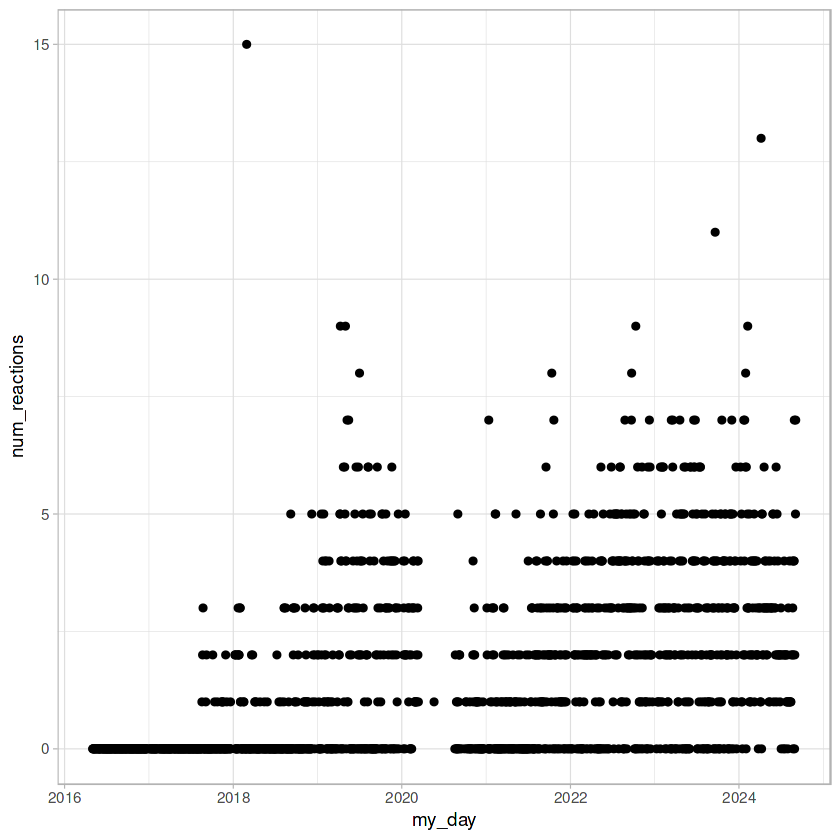

In [64]:
MLM %>% ggplot(aes(y = num_reactions, x = my_day)) + 
    geom_point()

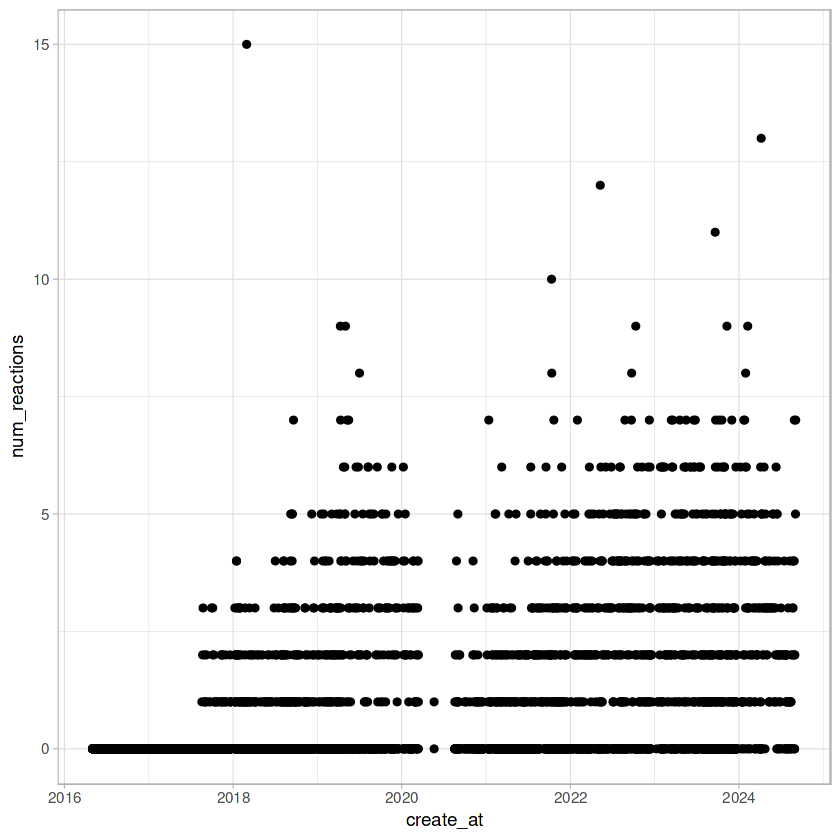

In [68]:
messages %>% ggplot(aes(y = num_reactions, x = create_at)) + 
    geom_point()

In [69]:
messages %>% filter(num_reactions > 6) %>% arrange(-num_reactions)

post_id,create_at,message,username,num_reactions,num_files
<chr>,<dttm>,<chr>,<chr>,<dbl>,<dbl>
ny6cuue9ni8aikah6jgcterg7a,2018-02-28 09:51:48,Heute gibt es Kuchen,williamlopez,15,0
obxcr16ckbfwmrri6hfmqqyz4e,2024-04-06 21:28:55,"For the cooking session on Wednesday, I selected Spätzle with melted cheese and onions (plus cucumber salad). Please react until Tuesday if you want to participate, and contact me if you need a vegan option or if you have other dietary requirements.",iimog,13,0
wr7pb8n6cif7tdda9cmzek3k8c,2022-05-10 14:06:50,"Our first CCTB cooking session was a success, thanks Jana for organizing :relaxed: The next session is planned for Tuesday, the 31st of May. Feel free to join and sign up in the pad: https://hackmd.io/PhOpF6VoQN2D9Mg6R3K9bQ?view",kerstin,12,1
pneqq41bsfrt5gc74onrrzrhrw,2023-09-20 10:41:54,I'm probably in a meeting until ~11:30 lunch after?,robinroelz,11,0
guom6u5mg3y8pmpmh6on4qh6mw,2021-10-11 11:08:46,"Happy birthday, Anne!! :tada: :dizzy: :birthday: :muscle: :champagne: The cake is delicious btw, thanks!",jscabral,10,0
83yipzcknf8rukcjcxasq36e3h,2019-04-10 11:42:43,:plate_with_cutlery:,lulei,9,0
5wgrqojm1ffizet76dtswhdeuh,2019-05-02 11:32:23,soon ?,art,9,0
6afg99bst78tmqu6suc8y4wkoc,2022-10-11 10:37:00,":fallen_leaf: There is chocolate cake^ in the kitchen :fallen_leaf: ^ *non-vegan, but gluten-free*",anne.lewerentz,9,0
qjdrbg73wtdyjgpi4n8xa3cq5c,2023-11-10 10:45:04,Mensa at 1115 ?,andreaskuhn,9,0


In [71]:
MLM %>% group_by(username) %>% summarize(mnr = mean(num_reactions)) %>% arrange(-mnr)

username,mnr
<chr>,<dbl>
williamlopez,15.00000000
dharanish,8.00000000
gosia,5.00000000
bettinavignolo,4.00000000
melanie,3.71428571
marko_korb,3.50000000
prithivi,3.50000000
angie,3.16666667
rosina_,3.14285714
